# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Egl-9-is-epistatic-to-vhl-1" data-toc-modified-id="Egl-9-is-epistatic-to-vhl-1-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Egl-9 is epistatic to vhl-1</a></div><div class="lev1 toc-item"><a href="#hif-1-suppresses-egl-9" data-toc-modified-id="hif-1-suppresses-egl-9-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>hif-1 suppresses egl-9</a></div><div class="lev1 toc-item"><a href="#Transitivity-holds-in-transcriptomes" data-toc-modified-id="Transitivity-holds-in-transcriptomes-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Transitivity holds in transcriptomes</a></div><div class="lev2 toc-item"><a href="#Predicting-the-epistasis-between-egl-9-and-vhl-1-using-the-rhy-1-transcriptome" data-toc-modified-id="Predicting-the-epistasis-between-egl-9-and-vhl-1-using-the-rhy-1-transcriptome-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Predicting the epistasis between <em>egl-9</em> and <em>vhl-1</em> using the <em>rhy-1</em> transcriptome</a></div><div class="lev2 toc-item"><a href="#Predicting-the-epistasis-between-egl-9-and-hif-1-using-the-rhy-1-transcriptome" data-toc-modified-id="Predicting-the-epistasis-between-egl-9-and-hif-1-using-the-rhy-1-transcriptome-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Predicting the epistasis between <em>egl-9</em> and <em>hif-1</em> using the <em>rhy-1</em> transcriptome</a></div>

In [1]:
# important stuff:
import os
import pandas as pd
import numpy as np

# TEA and morgan
import tissue_enrichment_analysis as tea
import morgan as morgan
import epistasis as epi
import gvars

# Graphics
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

from scipy.stats import gaussian_kde

# Magic function to make matplotlib inline;
# other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline. 
# There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [2]:
# Specify the genotypes to refer to:
single_mutants = ['b', 'c', 'd', 'e', 'g']
# Specify which genotypes are double mutants 
# and of what single mutants:
double_mutants = {'a' : 'bd', 'f':'bc'}

# initialize the morgan.hunt object:
thomas = morgan.hunt('target_id', 'b', 'tpm', 'qval')

# input the genmap file:
thomas.add_genmap('../input/library_genotype_mapping.txt', comment='#')

# add the names of the single mutants
thomas.add_single_mutant(single_mutants)

# add the names of the double mutants
thomas.add_double_mutants(['a', 'f'], ['bd', 'bc'])

# set the q-value threshold for significance to its default value, 0.1
thomas.set_qval()

# Add the tpm files: 
kallisto_loc = '../input/kallisto_all/'
thomas.add_tpm(kallisto_loc, '/kallisto/abundance.tsv', '')

# load all the beta values for each genotype:
sleuth_loc = '../sleuth_all_adjusted/kallisto/'
for file in os.listdir("../sleuth_all_adjusted/kallisto"):
    if file[:4] == 'beta':
        letter = file[-5:-4].lower()
        thomas.add_beta(sleuth_loc + file, letter)
        thomas.beta[letter].sort_values('target_id', inplace=True)
        thomas.beta[letter].reset_index(inplace=True)

In [3]:
thomas.filter_data(0, 0.1)

Number of na genes: 232


In [4]:
genvar = gvars.genvars()

In [5]:
frames = []
for key, df in thomas.beta.items():
    df['genotype'] = genvar.fancy_mapping[key]
    df['code'] = key
    frames += [df]

tidy_data = pd.concat(frames)

In [6]:
hifoh = pd.read_csv('../output/hifoh_candidates.csv')

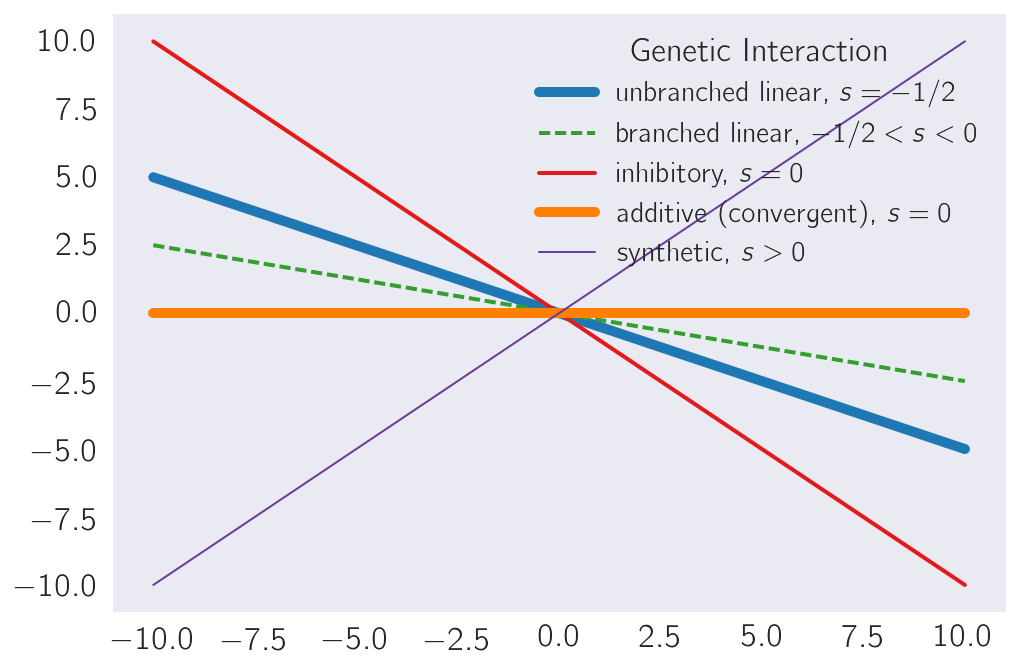

In [7]:
X = np.linspace(-10, 10)
Y = -1/2*X

plt.plot(X, -1/2*X, ls='-', color= '#1f78b4', lw=5, label='unbranched linear, $s=-1/2$')
plt.plot(X, -1/4*X, ls='--', color= '#33a02c', label='branched linear, $-1/2 < s < 0$')
plt.plot(X, -X, ls='-', lw=2, color= '#e31a1c', label='inhibitory, $s = 0$')
plt.plot(X, 0*X, 'k-', lw=5, color= '#ff7f00', label='additive (convergent), $s = 0$')
plt.plot(X, X, '-', lw=1,color= '#6a3d9a',  label='synthetic, $s > 0$')

lgd = plt.legend()
lgd.set_title('Genetic Interaction', prop=(mpl.font_manager.FontProperties(size=16)))
plt.savefig('../output/epistasis_plot_show.svg', bbox_inches='tight')

# Egl-9 is epistatic to vhl-1

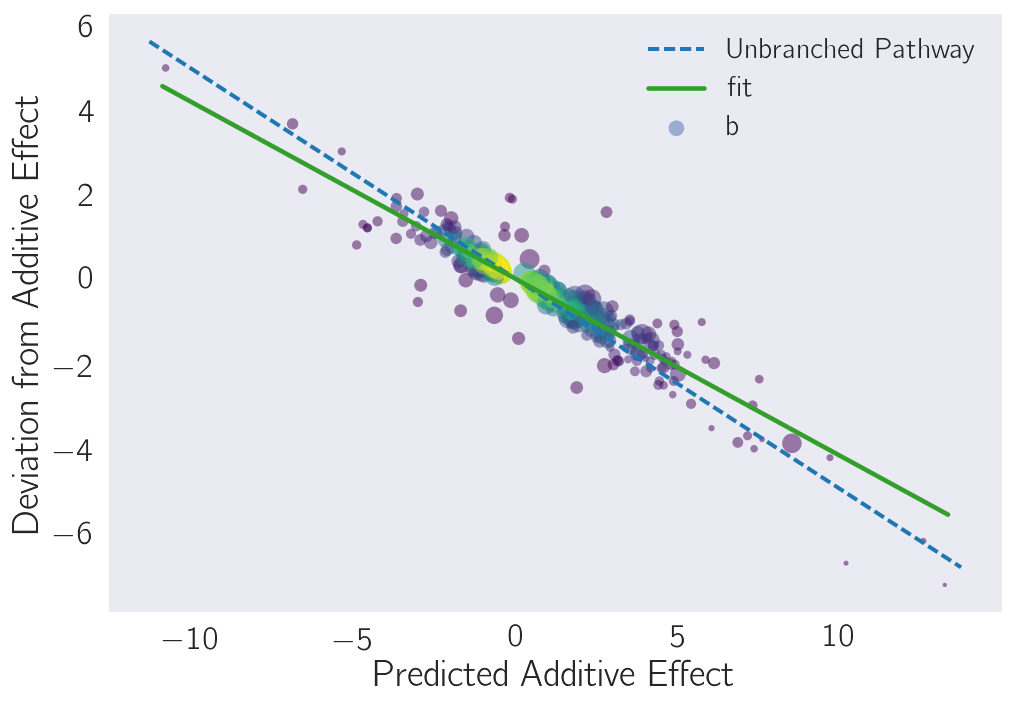

In [8]:
letter1 = 'b'
letter2 = 'd'
double = genvar.double_mapping[letter1 + letter2]
x, y, xy, ax = epi.epistasis_plot([letter1, letter2],
                                                      double, tidy_data)
plt.savefig('../output/epistasis{0}{1}.svg'.format(genvar.mapping[letter1], genvar.mapping[letter2]),
            bbox_inches='tight')

In [9]:
s, seb = epi.calculate_all_bootstraps(letter1, letter2, double, tidy_data, nsim=100)

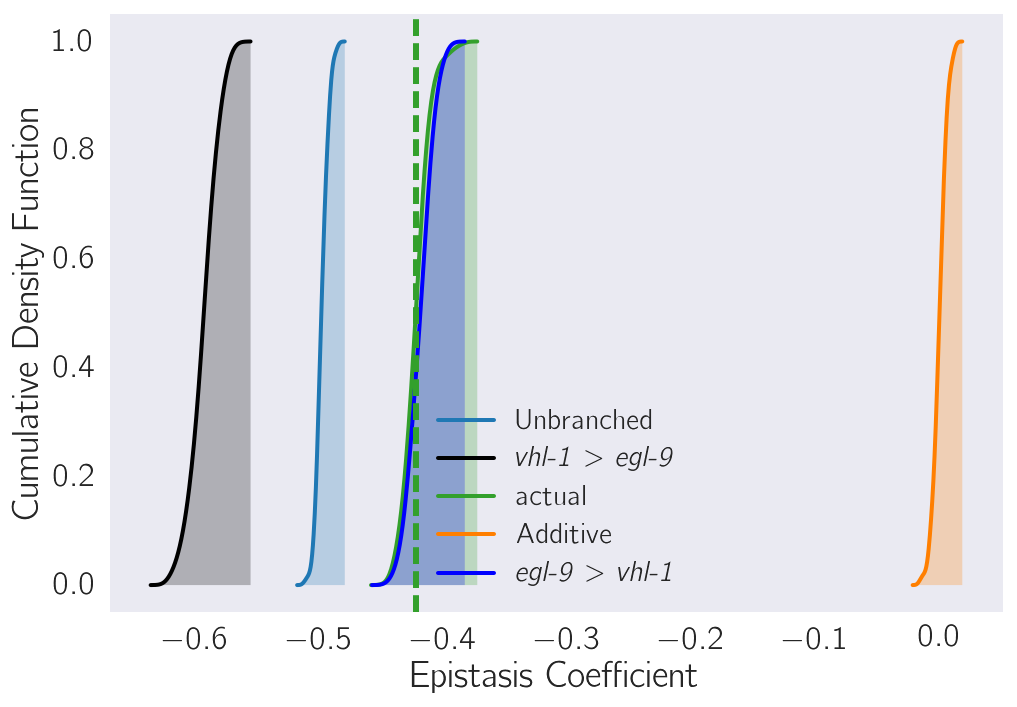

In [10]:
ax = epi.plot_bootstraps(letter1, letter2, s, cumulative=True, shade=True)
plt.xlabel('Epistasis Coefficient')
plt.ylabel('Cumulative Density Function')
plt.savefig('../output/kde-epistasis{0}{1}.svg'.format(genvar.mapping[letter1], genvar.mapping[letter2]),
            bbox_inches='tight')

# hif-1 suppresses egl-9

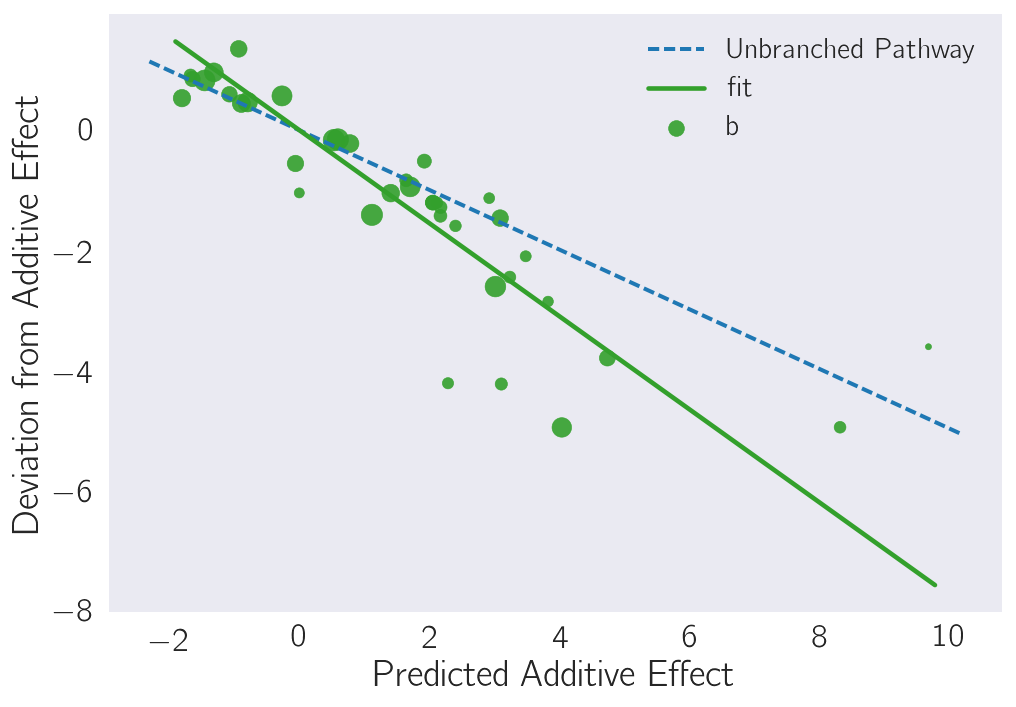

In [11]:
letter1 = 'b'
letter2 = 'c'
double = genvar.double_mapping[letter1 + letter2]
x, y, xy, ax = epi.epistasis_plot([letter1, letter2],
                                                      double, tidy_data)
plt.savefig('../output/epistasis{0}{1}.svg'.format(genvar.mapping[letter1], genvar.mapping[letter2]),
            bbox_inches='tight')

In [12]:
s, seb = epi.calculate_all_bootstraps(letter1, letter2, double, tidy_data, nsim=100)

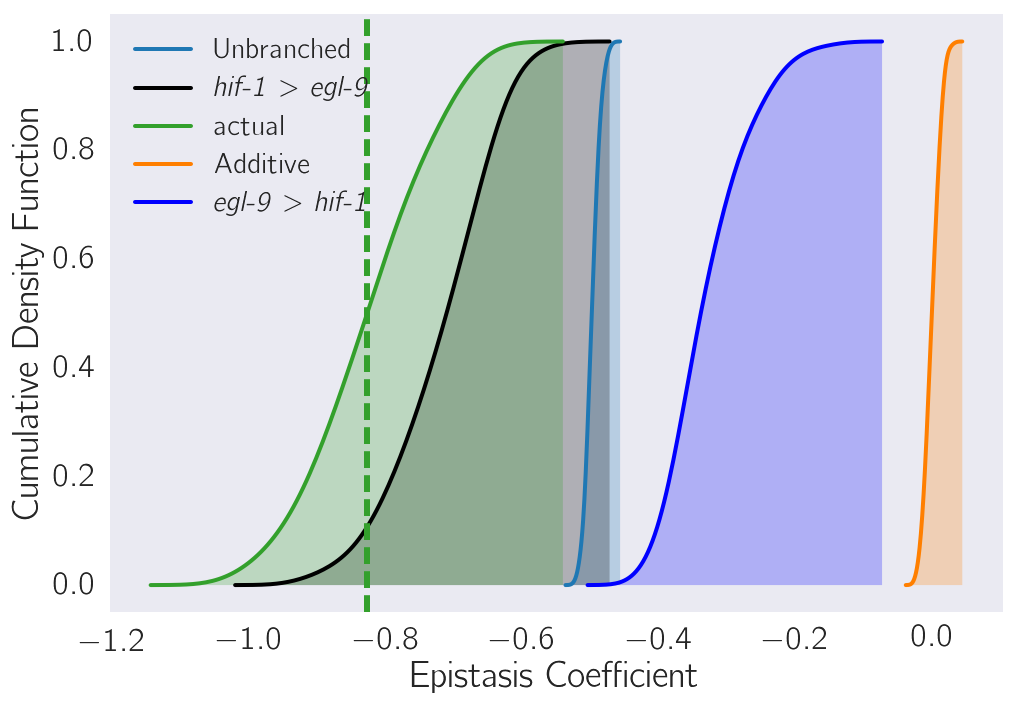

In [13]:
ax = epi.plot_bootstraps(letter1, letter2, s, cumulative=True, shade=True)
plt.xlabel('Epistasis Coefficient')
plt.ylabel('Cumulative Density Function')
plt.savefig('../output/kde-epistasis{0}{1}.svg'.format(genvar.mapping[letter1], genvar.mapping[letter2]),
            bbox_inches='tight')

# Transitivity holds in transcriptomes

## Predicting the epistasis between *egl-9* and *vhl-1* using the *rhy-1* transcriptome

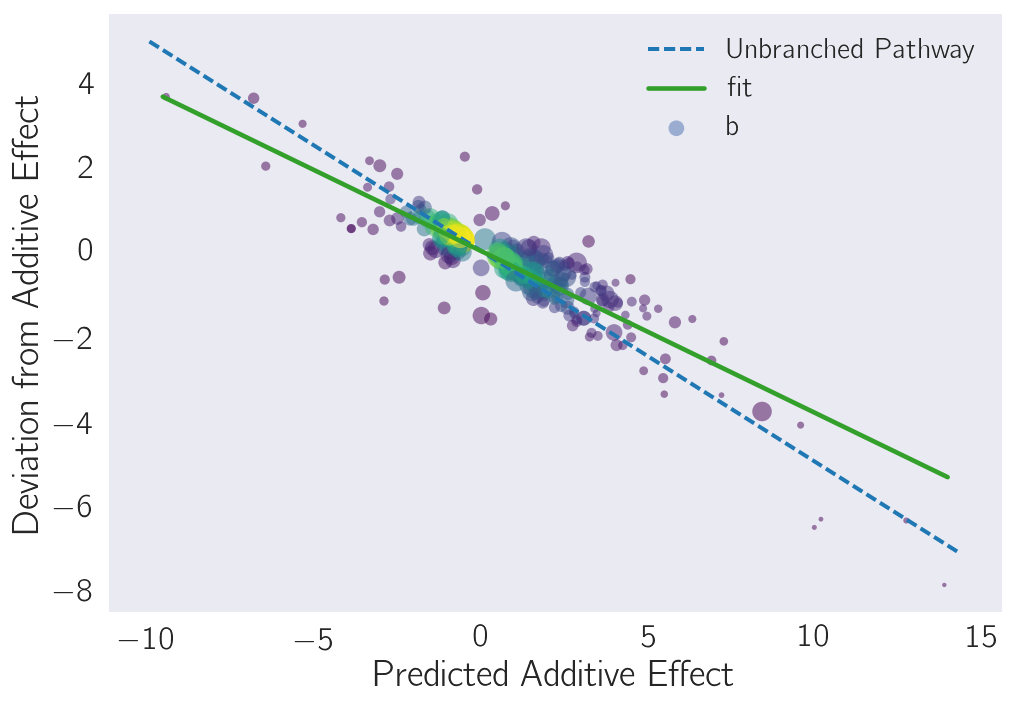

In [14]:
letter1 = 'e'
letter2 = 'd'
double = genvar.double_mapping['b' + letter2]
x, y, xy, ax = epi.epistasis_plot([letter1, letter2],
                                                      double, tidy_data)

In [15]:
s, seb = epi.calculate_all_bootstraps(letter1, letter2, double, tidy_data, nsim=100)

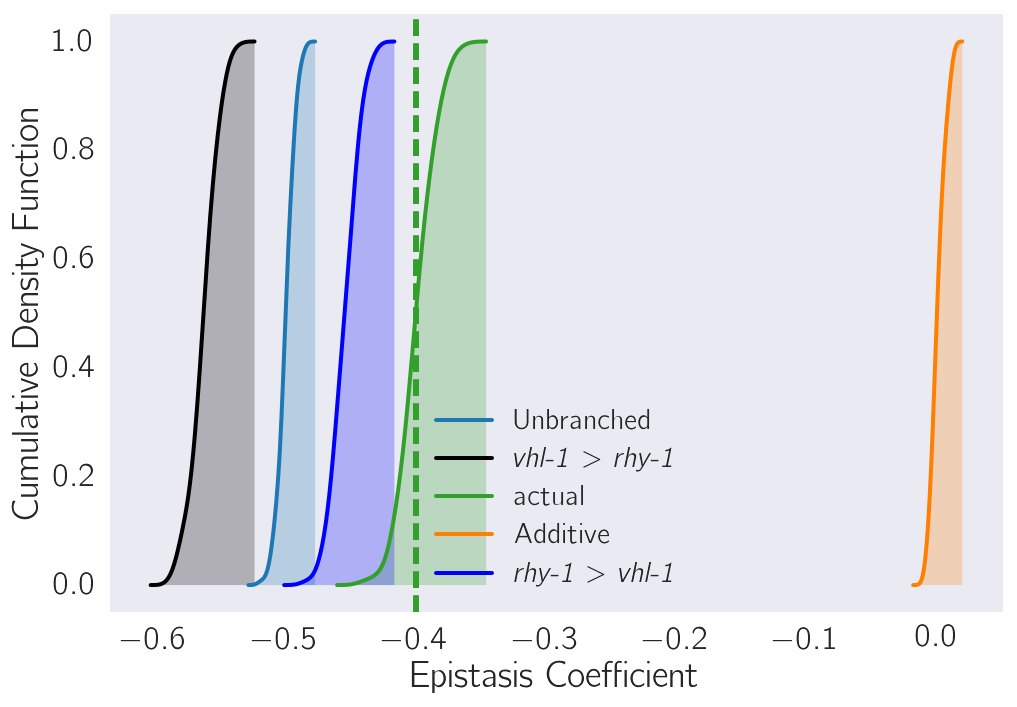

In [16]:
ax = epi.plot_bootstraps(letter1, letter2, s, cumulative=True, shade=True)
plt.xlabel('Epistasis Coefficient')
plt.ylabel('Cumulative Density Function')
plt.savefig('../output/kde-epistasis{0}{1}.svg'.format(genvar.mapping[letter1], genvar.mapping[letter2]),
            bbox_inches='tight')

## Predicting the epistasis between *egl-9* and *hif-1* using the *rhy-1* transcriptome

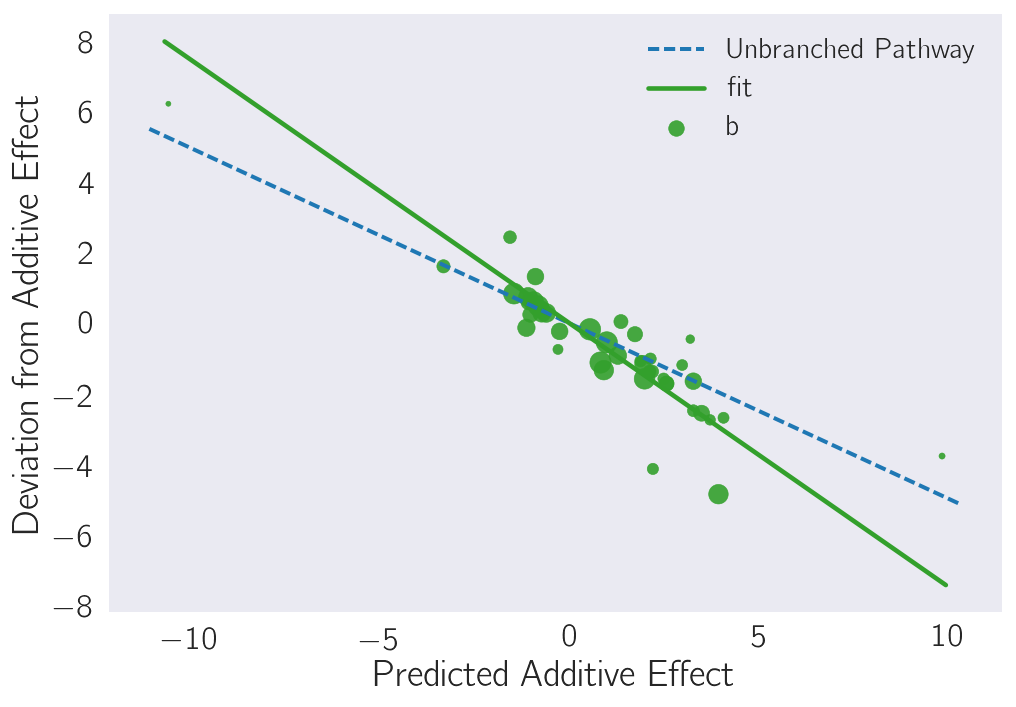

In [17]:
letter1 = 'e'
letter2 = 'c'
double = genvar.double_mapping['b' + letter2]
x, y, xy, ax = epi.epistasis_plot([letter1, letter2],
                                                      double, tidy_data)

In [18]:
s, seb = epi.calculate_all_bootstraps(letter1, letter2, double, tidy_data, nsim=100)

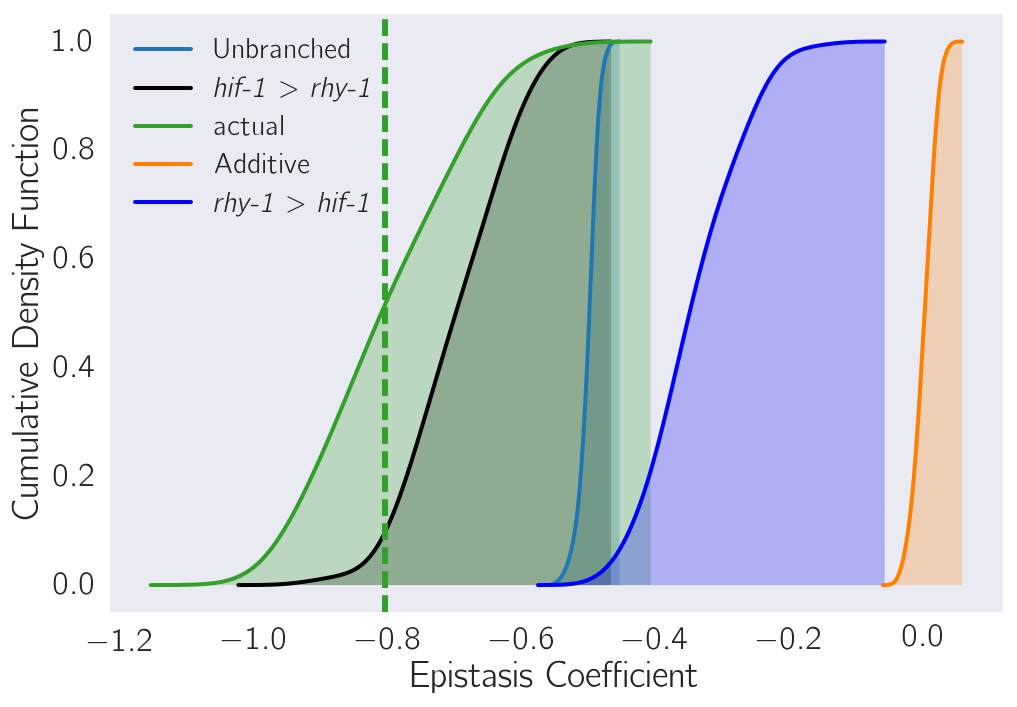

In [19]:
ax = epi.plot_bootstraps(letter1, letter2, s, cumulative=True, shade=True)
plt.xlabel('Epistasis Coefficient')
plt.ylabel('Cumulative Density Function')
plt.savefig('../output/kde-epistasis{0}{1}.svg'.format(genvar.mapping[letter1], genvar.mapping[letter2]),
            bbox_inches='tight')